<a href="https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/src/(FAN)%20Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary modules

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wf
import time
import glob
import datetime

from tqdm import trange

# Import Keras modules

from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


Using TensorFlow backend.


In [0]:
# Mount google drive

# from google.colab import drive
# drive.mount('/content/gdrive')
# os.listdir('gdrive/My Drive/Colab')

In [0]:
# Set data directories

# dataPath = 'gdrive/My Drive/Colab/Data'
dataPath = '''D:\\0_Joowhan's Paper\\Synthesized\\Total'''
modelPath = '''D:/0_Joowhan's Paper/Synthesized/Total/Model'''

# Changed variable names to normal and fault
# Changed variable names from folder to path
# Need to consider multiple folders
# Need to add files to be tested

# folderNormal = 'A3F1P3'
# folderFault = 'A3F5P3'

folderNormal = ['A1F1P1', 'A2F1P1', 'A1F2P1', 'A1F1P2', 'A2F2P1', 'A1F2P2', 'A2F1P2', 'A2F2P2']

folderFault = list()

for x in range(1, 6):
    for y in range(1, 6):
        for z in range(1, 6):
            if (x == 5 or y == 5 or z == 5):
                folderFault.append('A{}F{}P{}'.format(x, y, z))

pathNormal = list()
pathFault = list()

for i in range(len(folderNormal)):
    pathNormal.append(dataPath + '/' + folderNormal[i])
    
for i in range(len(folderFault)):
    pathFault.append(dataPath + '/' + folderFault[i])

normIdx = list()
faultIdx = list()
filesNormal = list()
filesFault = list()

for i in range(len(pathNormal)):
    filesNormalTemp = os.listdir(pathNormal[i])
    filesNormalTemp = [file for file in filesNormalTemp if file.endswith('.wav')]
    
    randIdx = np.random.choice(range(1000), round(2 * 1000/len(pathNormal)), replace=False)
    randIdx.sort()
    normIdx.append(randIdx)
    
    filesNormalSelected = [pathNormal[i] + '/' + filesNormalTemp[j] for j in randIdx]
    
    filesNormal = filesNormal + filesNormalSelected
    
    
for i in range(len(pathFault)):
    filesFaultTemp = os.listdir(pathFault[i])
    filesFaultTemp = [file for file in filesFaultTemp if file.endswith('.wav')]
    
    randIdx = np.random.choice(range(1000), round(2 * 1000/len(pathFault)), replace=False)
    randIdx.sort()
    faultIdx.append(randIdx)
    
    filesFaultSelected = [pathFault[i] + '/' + filesFaultTemp[j] for j in randIdx]
    
    filesFault = filesFault + filesFaultSelected

In [0]:
print(len(filesNormal))
print(len(filesFault))

2000
2013


In [0]:
# Specgram settings

nsc = 1470
nov = nsc/2
nff = nsc 
imgSize = 224

pretrainedModel = 'VGG19'
pretrainedModel = 'Xception'
pretrainedModel = 'ResNet50'

lastActivation = 'softmax'
sizeBatch = 4
numEpochs = 8
verb = 1


# Learning parameters

trainingRatio = 0.8

In [0]:
# Execution confirmed with new variable names

# Check whether npy file exists 

#npyNormalPath = glob.glob(pathNormal + '/' + '*.npy')


if len(folderNormal) == 1:
    npyNormalPath = glob.glob(pathNormal[0] + '/' + '*.npy')
else:
    npyNormalPath = list()
    
if (len(npyNormalPath) == 1):
    imgsNormal = np.load(npyNormalPath[0])

else:
    imgsNormal = np.zeros([len(filesNormal), imgSize, imgSize])
    
    for i in trange(len(filesNormal)):
        fs, dataInt16 = wf.read(filesNormal[i])
        dataFloat = dataInt16 / (2 ** 15)
        Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                           window=np.hamming(nsc), cmap='viridis')
        plt.close()
        imgsNormal[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
#     np.save(pathNormal + '/' + folderNormal + '.npy', imgsNormal)
        
print('Normal Image Shape: {}'.format(imgsNormal.shape))

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:27<00:00, 20.40it/s]


Normal Image Shape: (2000, 224, 224)


In [0]:
# Execution confined with new varible names

# Check whether npy file exists


if len(folderFault) == 1:
    npyFaultPath = glob.glob(pathFault[0] + '/' + '*.npy')
else:
    npyFaultPath = list()

if (len(npyFaultPath) == 1):
    imgsFault = np.load(npyFaultPath[0])

else:
    imgsFault = np.zeros([len(filesFault), imgSize, imgSize])

    for i in trange(len(filesFault)):
        fs, dataInt16 = wf.read(filesFault[i])
        dataFloat = dataInt16 / (2 ** 15)
        Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                           window=np.hamming(nsc), cmap='viridis')
        plt.close()
        imgsFault[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
#     np.save(pathFault + '/' + folderFault + '.npy', imgsFault)
        
print('Fault Image Shape: {}'.format(imgsFault.shape))

100%|██████████████████████████████████████████████████████████████████████████████| 2013/2013 [01:31<00:00, 22.10it/s]


Fault Image Shape: (2013, 224, 224)


In [0]:
# Change name from imgsF1 or imgsF5 to imgsNormal and imgsFault

dataNumNormal = len(imgsNormal)
dataNumFault = len(imgsFault)
dataNumNormalTrain = int(dataNumNormal * trainingRatio)
dataNumFaultTrain = int(dataNumFault * trainingRatio)
dataNumNormalTest = dataNumNormal - dataNumNormalTrain
dataNumFaultTest = dataNumFault - dataNumFaultTrain

print('Normal Train:Test = {:d}:{:d}'.format(dataNumNormalTrain, dataNumNormalTest))
print('Fault  Train:Test = {:d}:{:d}\n'.format(dataNumFaultTrain, dataNumFaultTest))

trainIdxNormal = np.random.choice(dataNumNormal - 1, dataNumNormalTrain, replace=False)
testIdxNormal = list(set(range(0, dataNumNormal)) - set(trainIdxNormal))

trainImgsNormal = imgsNormal[trainIdxNormal, :, :]
testImgsNormal = imgsNormal[testIdxNormal, :, :]

print('Normal Training Image Shape {}'.format(trainImgsNormal.shape))
print('Normal Test Image Shape {}\n'.format(testImgsNormal.shape))

trainIdxFault  = np.random.choice(dataNumFault - 1, dataNumFaultTrain, replace=False)
testIdxFault = list(set(range(0, dataNumFault)) - set(trainIdxFault))

trainImgsFault = imgsFault[trainIdxFault, :, :]
testImgsFault = imgsFault[testIdxFault, :, :]

print('Fault Training Image Shape {}'.format(trainImgsFault.shape))
print('Fault Test Image Shape {}\n'.format(testImgsFault.shape))

trainImgs = np.vstack([trainImgsNormal, trainImgsFault])
testImgs = np.vstack([testImgsNormal, testImgsFault])

print('Training Image Shape {}'.format(trainImgs.shape))
print('Test Image Shape {}'.format(testImgs.shape))

Normal Train:Test = 1600:400
Fault  Train:Test = 1610:403

Normal Training Image Shape (1600, 224, 224)
Normal Test Image Shape (400, 224, 224)

Fault Training Image Shape (1610, 224, 224)
Fault Test Image Shape (403, 224, 224)

Training Image Shape (3210, 224, 224)
Test Image Shape (803, 224, 224)


In [0]:
trainMean = np.mean(trainImgs)
trainStd = np.std(trainImgs)

print('Mean of Training Image: {}'.format(trainMean))
print('Standard Deviation of Training Image: {}'.format(trainStd))

Mean of Training Image: -78.73910851966106
Standard Deviation of Training Image: 8.920973145586164


In [0]:
# Should Change Norm to Normalized

trainImgsNorm = (trainImgs - trainMean) / trainStd
testImgsNorm = (testImgs - trainMean) / trainStd

trainImgsNorm = trainImgsNorm.reshape(list(trainImgsNorm.shape) + [1])
testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

In [0]:
X_train = np.stack([trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0]], axis = -1)
X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

print('X_train Shape: {}'.format(X_train.shape))
print('X_test  Shape: {}'.format(X_test.shape))

X_train Shape: (3210, 224, 224, 3)
X_test  Shape: (803, 224, 224, 3)


In [0]:
trainLabelNormal = np.stack((np.ones(dataNumNormalTrain), np.zeros(dataNumNormalTrain)), axis = -1)
testLabelNormal = np.stack((np.ones(dataNumNormalTest), np.zeros(dataNumNormalTest)), axis = -1)

trainLabelFault = np.stack((np.zeros(dataNumFaultTrain), np.ones(dataNumFaultTrain)), axis = -1)
testLabelFault = np.stack((np.zeros(dataNumFaultTest), np.ones(dataNumFaultTest)), axis = -1)

Y_train = np.vstack((trainLabelNormal, trainLabelFault))
Y_test = np.vstack((testLabelNormal, testLabelFault))

print('Y_train Normal:Fault = {:d}:{:d}'.format(len(trainLabelNormal), len(trainLabelFault)))
print('Y_test  Normal:Fault = {:d}:{:d}'.format(len(testLabelNormal), len(testLabelFault)))

Y_train Normal:Fault = 1600:1610
Y_test  Normal:Fault = 400:403


In [0]:
from keras.applications import VGG19
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3

# pretrainedModel = 'ResNet50'
# lastActivation = 'softmax'
# lossFunction = 'binary_crossentropy'
# sizeBatch = 2
# numEpochs = 2
# verb = 1

# Refresh all background variables
K.clear_session()

input_tensor = Input(shape=(imgSize, imgSize, 3))

# Building sequential model with name 'model'
model = Sequential()

# Model selection

if (pretrainedModel == 'VGG16'):
    
    modelWoTop = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'VGG19'):
    
    modelWoTop = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
              
elif pretrainedModel == 'ResNet50':
    
    modelWoTop = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'InceptionV3'):
    modelWoTop = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'Xception'):
    modelWoTop = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
                      
elif (pretrainedModel == 'DenseNet169'):

    modelWoTop = DenseNet169(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'DenseNet201'):
    modelWoTop = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
else:
    print('Invalid Pretrained Model Selection')
    
              

# Model compiling

print('Compiling Pretrained {} Model'.format(model.layers[0].name))
              
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\users\주환\appdata\local\conda\conda\envs\paper\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Compiling Pretrained resnet50 Model


In [0]:
print('Training Pretrained {} Model'.format(model.layers[0].name))
print('Batch Size: {}\t Epochs: {}\t\n'.format(sizeBatch, numEpochs))

model.fit(X_train, Y_train,
          batch_size=sizeBatch, epochs=numEpochs, verbose=1,
          validation_data=(X_test, Y_test))

Y_pred = model.predict(X_test)

Training Pretrained resnet50 Model
Batch Size: 4	 Epochs: 8	

Train on 3210 samples, validate on 803 samples
Epoch 1/8
3210/3210 [==============================] - 146s 46ms/step - loss: 3.3483 - acc: 0.6399 - val_loss: 7.3937 - val_acc: 0.3935
Epoch 2/8
3210/3210 [==============================] - 135s 42ms/step - loss: 2.0102 - acc: 0.7757 - val_loss: 5.8416 - val_acc: 0.6065
Epoch 3/8
3210/3210 [==============================] - 134s 42ms/step - loss: 1.0598 - acc: 0.8682 - val_loss: 0.5361 - val_acc: 0.9103
Epoch 4/8
3210/3210 [==============================] - 134s 42ms/step - loss: 1.1773 - acc: 0.8533 - val_loss: 0.8054 - val_acc: 0.8144
Epoch 5/8
3210/3210 [==============================] - 135s 42ms/step - loss: 0.9336 - acc: 0.8713 - val_loss: 0.2796 - val_acc: 0.9390
Epoch 6/8
3210/3210 [==============================] - 134s 42ms/step - loss: 0.9254 - acc: 0.8813 - val_loss: 0.3036 - val_acc: 0.9440
Epoch 7/8
3210/3210 [==============================] - 134s 42ms/step - los

In [0]:
model.fit(X_train, Y_train,
          batch_size=sizeBatch, epochs=8, verbose=1,
          validation_data=(X_test, Y_test))

Train on 3210 samples, validate on 803 samples
Epoch 1/8
3210/3210 [==============================] - 134s 42ms/step - loss: 0.7968 - acc: 0.8688 - val_loss: 0.1884 - val_acc: 0.9315
Epoch 2/8
3210/3210 [==============================] - 135s 42ms/step - loss: 0.7971 - acc: 0.8891 - val_loss: 0.3949 - val_acc: 0.8854
Epoch 3/8
3210/3210 [==============================] - 135s 42ms/step - loss: 0.7327 - acc: 0.9003 - val_loss: 0.1601 - val_acc: 0.9452
Epoch 4/8
3210/3210 [==============================] - 134s 42ms/step - loss: 0.7035 - acc: 0.9078 - val_loss: 0.1490 - val_acc: 0.9514
Epoch 5/8
3210/3210 [==============================] - 132s 41ms/step - loss: 0.7781 - acc: 0.9040 - val_loss: 1.9993 - val_acc: 0.8443
Epoch 6/8
3210/3210 [==============================] - 135s 42ms/step - loss: 0.7409 - acc: 0.9019 - val_loss: 0.1311 - val_acc: 0.9601
Epoch 7/8
3210/3210 [==============================] - 134s 42ms/step - loss: 0.7017 - acc: 0.9140 - val_loss: 0.1646 - val_acc: 0.9415
E

In [0]:
model.fit(X_train, Y_train,
          batch_size=6, epochs=15, verbose=1,
          validation_data=(X_test, Y_test))

Train on 3210 samples, validate on 803 samples
Epoch 1/15
3210/3210 [==============================] - 103s 32ms/step - loss: 1.7855 - acc: 0.8308 - val_loss: 7.1453 - val_acc: 0.5467
Epoch 2/15
3210/3210 [==============================] - 98s 31ms/step - loss: 1.7554 - acc: 0.8489 - val_loss: 2.3184 - val_acc: 0.8294
Epoch 3/15
3210/3210 [==============================] - 98s 31ms/step - loss: 2.4889 - acc: 0.7919 - val_loss: 1.3336 - val_acc: 0.8817
Epoch 4/15
3210/3210 [==============================] - 98s 30ms/step - loss: 2.9599 - acc: 0.7673 - val_loss: 2.4098 - val_acc: 0.8082
Epoch 5/15
3210/3210 [==============================] - 98s 31ms/step - loss: 2.4762 - acc: 0.7953 - val_loss: 2.2964 - val_acc: 0.8232
Epoch 6/15
3210/3210 [==============================] - 98s 31ms/step - loss: 1.5194 - acc: 0.8523 - val_loss: 0.8571 - val_acc: 0.9141
Epoch 7/15
3210/3210 [==============================] - 98s 31ms/step - loss: 1.5202 - acc: 0.8639 - val_loss: 0.4340 - val_acc: 0.9390


In [0]:
model.fit(X_train, Y_train,
          batch_size=6, epochs=10, verbose=1,
          validation_data=(X_test, Y_test))

Train on 3210 samples, validate on 803 samples
Epoch 1/10
3210/3210 [==============================] - 97s 30ms/step - loss: 0.2344 - acc: 0.9536 - val_loss: 1.5700 - val_acc: 0.5255
Epoch 2/10
3210/3210 [==============================] - 97s 30ms/step - loss: 0.3033 - acc: 0.9445 - val_loss: 0.1409 - val_acc: 0.9589
Epoch 3/10
3210/3210 [==============================] - 98s 30ms/step - loss: 0.2893 - acc: 0.9464 - val_loss: 0.1272 - val_acc: 0.9639
Epoch 4/10
3210/3210 [==============================] - 97s 30ms/step - loss: 0.6095 - acc: 0.9156 - val_loss: 0.2471 - val_acc: 0.9539
Epoch 5/10
3210/3210 [==============================] - 98s 30ms/step - loss: 0.4011 - acc: 0.9377 - val_loss: 0.1295 - val_acc: 0.9614
Epoch 6/10
3210/3210 [==============================] - 98s 30ms/step - loss: 0.2674 - acc: 0.9477 - val_loss: 0.1590 - val_acc: 0.9527
Epoch 7/10
3210/3210 [==============================] - 98s 31ms/step - loss: 0.3108 - acc: 0.9492 - val_loss: 0.1244 - val_acc: 0.9614
E

In [0]:
model.fit(X_train, Y_train,
          batch_size=6, epochs=2, verbose=1,
          validation_data=(X_test, Y_test))

Train on 3210 samples, validate on 803 samples
Epoch 1/2
3210/3210 [==============================] - 98s 31ms/step - loss: 0.2894 - acc: 0.9502 - val_loss: 0.1948 - val_acc: 0.9514
Epoch 2/2
3210/3210 [==============================] - 98s 31ms/step - loss: 0.2697 - acc: 0.9495 - val_loss: 0.1942 - val_acc: 0.9365


In [0]:
model.fit(X_train, Y_train,
          batch_size=6, epochs=2, verbose=1,
          validation_data=(X_test, Y_test))

Train on 3210 samples, validate on 803 samples
Epoch 1/2
3210/3210 [==============================] - 98s 31ms/step - loss: 0.2714 - acc: 0.9498 - val_loss: 0.1715 - val_acc: 0.9440
Epoch 2/2
3210/3210 [==============================] - 99s 31ms/step - loss: 0.2981 - acc: 0.9452 - val_loss: 0.1542 - val_acc: 0.9477


In [0]:
model.fit(X_train, Y_train,
          batch_size=6, epochs=8, verbose=1,
          validation_data=(X_test, Y_test))

Train on 3210 samples, validate on 803 samples
Epoch 1/8
3210/3210 [==============================] - 98s 31ms/step - loss: 0.2730 - acc: 0.9530 - val_loss: 0.1885 - val_acc: 0.9477
Epoch 2/8
3210/3210 [==============================] - 98s 31ms/step - loss: 0.5541 - acc: 0.9255 - val_loss: 0.5834 - val_acc: 0.8929
Epoch 3/8
3210/3210 [==============================] - 98s 30ms/step - loss: 0.5621 - acc: 0.9355 - val_loss: 0.2055 - val_acc: 0.9514
Epoch 4/8
3210/3210 [==============================] - 98s 31ms/step - loss: 0.4645 - acc: 0.9442 - val_loss: 0.1658 - val_acc: 0.9390
Epoch 5/8
3210/3210 [==============================] - 97s 30ms/step - loss: 0.2584 - acc: 0.9520 - val_loss: 0.1363 - val_acc: 0.9589
Epoch 6/8
3210/3210 [==============================] - 97s 30ms/step - loss: 0.2819 - acc: 0.9505 - val_loss: 0.1608 - val_acc: 0.9489
Epoch 7/8
3210/3210 [==============================] - 97s 30ms/step - loss: 0.3103 - acc: 0.9502 - val_loss: 0.1485 - val_acc: 0.9564
Epoch 8/

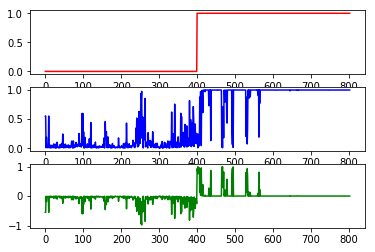

In [0]:
Y_pred = model.predict(X_test)

plt.subplot(3, 1, 1)
plt.plot(Y_test[:, 1], 'r')

plt.subplot(3, 1, 2)
plt.plot(Y_pred[:, 1], 'b')

plt.subplot(3, 1, 3)
plt.plot(Y_test[:, 1] - Y_pred[:, 1], 'g')

plt.show()

In [0]:
# : is not allowed in file name in windows OS
now = datetime.datetime.now()

modelSaved = '{}-{}_{}_{}.h5'.format(folderNormal, folderFault, pretrainedModel, now.strftime('%m-%d-%H-%M-%S'))
modelSaved = '{}-{}_{}_{}.h5'.format('Normal', 'Fault', pretrainedModel, now.strftime('%m-%d-%H-%M-%S'))
meanSaved = 'mean_{}.npy'.format(now.strftime('%m-%d-%H-%M-%S'))
stdSaved = 'std_{}.npy'.format(now.strftime('%m-%d-%H-%M-%S'))

inputStr = input('''Save Model as '{}'? (y/n)\n'''.format(modelSaved))

if (inputStr == 'y' or inputStr == 'Y'):  
    
    np.save(modelPath + '/' + meanSaved, trainMean)
    np.save(modelPath + '/' + stdSaved, trainStd)
    model.save(modelPath + '/' + modelSaved)



Save Model as 'Normal-Fault_ResNet50_10-15-17-07-45.h5'? (y/n)
y
